Displaying 2016 pair #500:
2016 Image: ../data/filtered/images_2016/Landsat8_SR_RGB_-54.72_-3.63_2016_08_16.tiff
2016 Target: ../data/filtered/targets_2016/Deforestation_-54.72_-3.63_2016_08_01.tiff


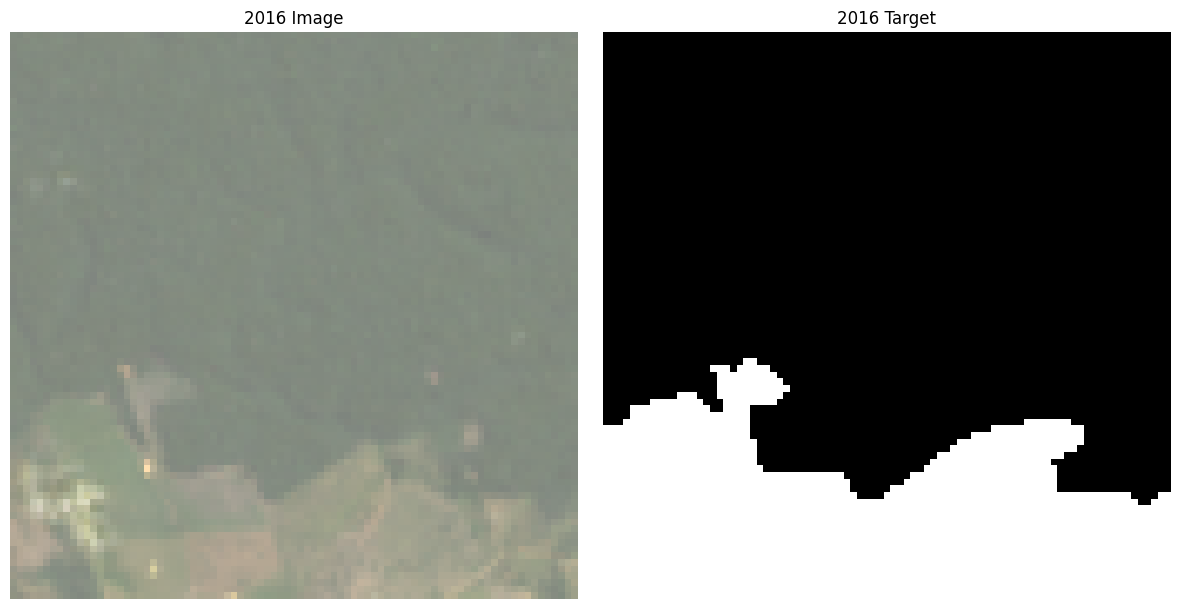

Displaying 2021 pair #500:
2021 Image: ../data/filtered/images_2021/Landsat8_SR_RGB_-54.72_-3.63_2021_05_26.tiff
2021 Target: ../data/filtered/targets_2021/Deforestation_-54.72_-3.63_2021_05_01.tiff


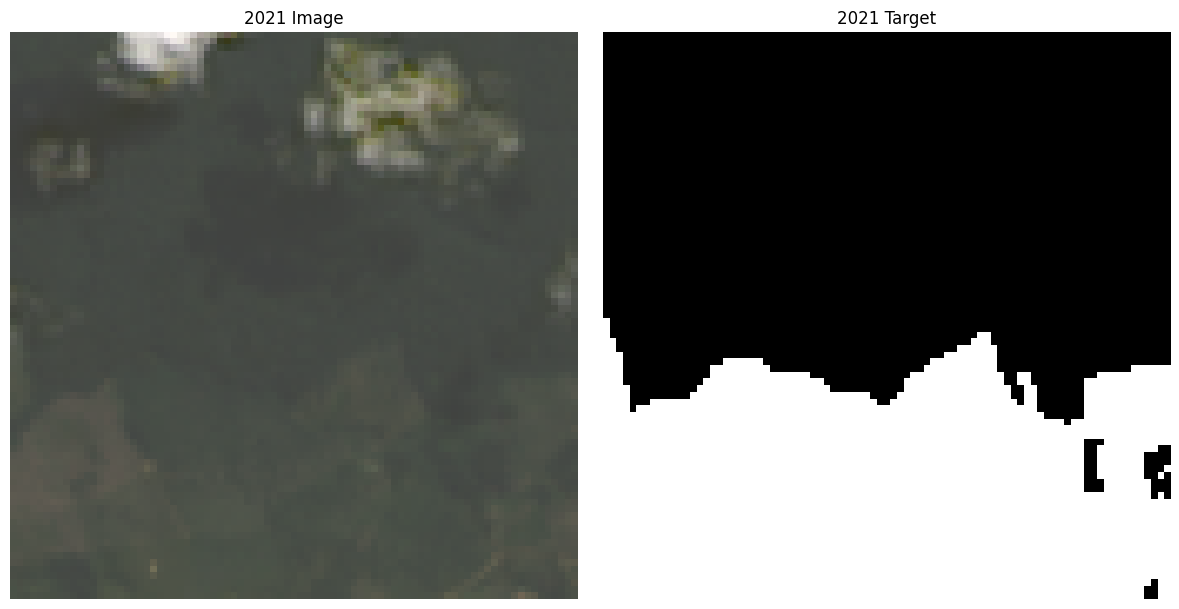

Enter 'n' for next, 'p' for previous, 'q' to quit:  q


Exiting exploration.


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re

# Paths to images and labels
IMAGES_2016_PATH = "../data/filtered/images_2016"
LABELS_2016_PATH = "../data/filtered/targets_2016"
IMAGES_2021_PATH = "../data/filtered/images_2021"
LABELS_2021_PATH = "../data/filtered/targets_2021"

def extract_coordinates(filename):
    """
    Extract coordinates from a filename as (longitude, latitude).

    Args:
        filename (str): Filename containing coordinates.

    Returns:
        tuple: Longitude and latitude as floats, or None if extraction fails.
    """
    pattern = r"[-+]?\d+\.\d+"
    coords = re.findall(pattern, filename)
    if len(coords) >= 2:
        return float(coords[0]), float(coords[1])
    return None

def find_matching_files(image_dir, label_dir):
    """
    Match images and labels based on their coordinates.

    Args:
        image_dir (str): Directory containing images.
        label_dir (str): Directory containing labels.

    Returns:
        list of tuples: List of matched (image_path, label_path) pairs.
    """
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tiff')])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.tiff')])

    matched_files = []
    for image_file in image_files:
        image_coords = extract_coordinates(image_file)
        if not image_coords:
            continue

        for label_file in label_files:
            label_coords = extract_coordinates(label_file)
            if image_coords == label_coords:
                matched_files.append((os.path.join(image_dir, image_file), os.path.join(label_dir, label_file)))
                break

    return matched_files

# Match files for 2016 and 2021
matched_files_2016 = find_matching_files(IMAGES_2016_PATH, LABELS_2016_PATH)
matched_files_2021 = find_matching_files(IMAGES_2021_PATH, LABELS_2021_PATH)

def plot_image_and_label(image_path, label_path, title_image, title_label):
    """
    Plot an image and its corresponding label.

    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the label file.
        title_image (str): Title for the image plot.
        title_label (str): Title for the label plot.
    """
    with Image.open(image_path) as img:
        image = np.array(img)
    with Image.open(label_path) as lbl:
        label = np.array(lbl.convert('L'))  # Convert to grayscale

    # Normalize the label values for display
    if label.max() > 1:  # Assuming the labels are in range [0, 255]
        label = label / 255.0  # Scale to [0, 1]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title(title_image)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(title_label)
    plt.imshow(label, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Interactive exploration
def explore_images(pairs_2016, pairs_2021):
    """
    Explore matched image-label pairs interactively.

    Args:
        pairs_2016 (list): Matched pairs of 2016 images and labels.
        pairs_2021 (list): Matched pairs of 2021 images and labels.
    """
    index = 500
    while True:
        # Display 2016 image and target
        print(f"Displaying 2016 pair #{index}:")
        print(f"2016 Image: {pairs_2016[index][0]}")
        print(f"2016 Target: {pairs_2016[index][1]}")
        plot_image_and_label(
            pairs_2016[index][0], pairs_2016[index][1],
            title_image="2016 Image", title_label="2016 Target"
        )

        # Display 2021 image and target
        print(f"Displaying 2021 pair #{index}:")
        print(f"2021 Image: {pairs_2021[index][0]}")
        print(f"2021 Target: {pairs_2021[index][1]}")
        plot_image_and_label(
            pairs_2021[index][0], pairs_2021[index][1],
            title_image="2021 Image", title_label="2021 Target"
        )

        # Prompt for navigation
        user_input = input("Enter 'n' for next, 'p' for previous, 'q' to quit: ").lower()
        if user_input == 'n':
            index = (index + 1) % len(pairs_2016)
        elif user_input == 'p':
            index = (index - 1) % len(pairs_2016)
        elif user_input == 'q':
            print("Exiting exploration.")
            break
        else:
            print("Invalid input. Please enter 'n', 'p', or 'q'.")

# Start exploration
explore_images(matched_files_2016, matched_files_2021)

In [10]:
def calculate_deforestation_area(target_2016_path, target_2021_path):
    """
    Calculate the deforested area between 2016 and 2021.

    Args:
        target_2016_path (str): Path to the 2016 target file.
        target_2021_path (str): Path to the 2021 target file.

    Returns:
        dict: A dictionary containing areas of forest, non-forest, and deforestation percentage.
    """
    with Image.open(target_2016_path) as lbl_2016:
        target_2016 = np.array(lbl_2016.convert('L'))

    with Image.open(target_2021_path) as lbl_2021:
        target_2021 = np.array(lbl_2021.convert('L'))

    # Normalize the labels if necessary
    if target_2016.max() > 1:
        target_2016 = target_2016 / 255.0
    if target_2021.max() > 1:
        target_2021 = target_2021 / 255.0

    # Calculate areas
    forest_2016 = np.sum(target_2016 == 1)
    forest_2021 = np.sum(target_2021 == 1)
    non_forest_2016 = np.sum(target_2016 == 0)
    non_forest_2021 = np.sum(target_2021 == 0)

    # Calculate deforestation percentage
    deforested_area = forest_2016 - forest_2021
    deforestation_percentage = (deforested_area / forest_2016) * 100 if forest_2016 > 0 else 0

    return {
        "forest_2016": forest_2016,
        "forest_2021": forest_2021,
        "non_forest_2016": non_forest_2016,
        "non_forest_2021": non_forest_2021,
        "deforested_area": deforested_area,
        "deforestation_percentage": deforestation_percentage
    }

# Example usage
target_2016_path = target_paths_2016[500]  # Use the first target from 2016
target_2021_path = target_paths_2021[500]  # Use the corresponding target from 2021

deforestation_stats = calculate_deforestation_area(target_2016_path, target_2021_path)

print(f"Forest area in 2016: {deforestation_stats['forest_2016']} pixels")
print(f"Forest area in 2021: {deforestation_stats['forest_2021']} pixels")
print(f"Non-forest area in 2016: {deforestation_stats['non_forest_2016']} pixels")
print(f"Non-forest area in 2021: {deforestation_stats['non_forest_2021']} pixels")
print(f"Deforested area: {deforestation_stats['deforested_area']} pixels")
print(f"Deforestation percentage: {deforestation_stats['deforestation_percentage']:.2f}%")

NameError: name 'target_paths_2016' is not defined